# Task 2: Customer Segmentation for Marketing
## Demographic + Economic Segmentation using K-Means Clustering

**Goal:** Create demographic and socio-economic segments that support:
- Different promotions (discount vs premium)
- Different products (family bundles vs essentials vs prosumer)
- Different messaging (convenience vs value vs trust/quality)

**Approach:**
1. Select demographic and economic features
2. Preprocess data (cleaning, encoding, scaling)
3. Fit K-Means for multiple K values (3-8) and evaluate metrics
4. Select optimal K based on metrics and business interpretability
5. Profile segments and create marketing recommendations

## Step 0: Import Libraries and Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
data_path = '../TakeHomeProject/census-bureau.data'
columns_path = '../TakeHomeProject/census-bureau.columns'

with open(columns_path, 'r') as f:
    columns = [line.strip() for line in f.readlines()]

df = pd.read_csv(data_path, names=columns, skipinitialspace=True)

print(f"Dataset shape: {df.shape}")

Dataset shape: (199523, 42)


## Step 1: Feature Selection

Based on the segmentation plan, we'll select:

**A) Demographic / Life-stage features:**
- age
- marital stat
- education
- detailed household and family stat
- family members under 18
- enroll in edu inst last wk
- citizenship

**B) Economic / Employment features:**
- major occupation code
- major industry code
- class of worker
- full or part time employment stat
- weeks worked in year
- own business or self employed
- num persons worked for employer
- member of a labor union
- wage per hour
- capital gains
- capital losses
- dividends from stocks

In [3]:
demographic_features = [
    'age',
    'marital stat',
    'education',
    'detailed household and family stat',
    'family members under 18',
    'enroll in edu inst last wk',
    'citizenship'
]

economic_features = [
    'major occupation code',
    'major industry code',
    'class of worker',
    'full or part time employment stat',
    'weeks worked in year',
    'own business or self employed',
    'num persons worked for employer',
    'member of a labor union',
    'wage per hour',
    'capital gains',
    'capital losses',
    'dividends from stocks'
]

clustering_features = demographic_features + economic_features

# Keep for profiling/reporting only
profile_features = ['label', 'weight']

print(f"Total clustering features: {len(clustering_features)}")
print(f"\nDemographic features ({len(demographic_features)}): {demographic_features}")
print(f"\nEconomic features ({len(economic_features)}): {economic_features}")

# Create working dataframe
df_work = df[clustering_features + profile_features].copy()
print(f"\nWorking dataset shape: {df_work.shape}")

Total clustering features: 19

Demographic features (7): ['age', 'marital stat', 'education', 'detailed household and family stat', 'family members under 18', 'enroll in edu inst last wk', 'citizenship']

Economic features (12): ['major occupation code', 'major industry code', 'class of worker', 'full or part time employment stat', 'weeks worked in year', 'own business or self employed', 'num persons worked for employer', 'member of a labor union', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

Working dataset shape: (199523, 21)


## Step 2: Data Preprocessing

Critical preprocessing steps for K-Means:
1. Clean missing values (replace "?" with NaN)
2. Handle "Not in universe" values
3. Engineer sparse financial features (binary indicators + log transforms)
4. Encode categorical variables
5. Scale numeric features

In [4]:
# Step 2.1: Clean missing values (replace "?" with NaN)
print("Step 2.1: Cleaning missing values...")

for col in df_work.columns:
    if df_work[col].dtype == 'object':
        df_work[col] = df_work[col].replace(['?', ' ?', '? ', ' ? '], np.nan)
        df_work[col] = df_work[col].str.strip()

missing_counts = df_work[clustering_features].isnull().sum()
missing_pct = (missing_counts / len(df_work)) * 100

print("\nMissing values summary:")
print(pd.DataFrame({
    'Missing Count': missing_counts[missing_counts > 0],
    'Missing %': missing_pct[missing_counts > 0]
}).sort_values('Missing %', ascending=False))

Step 2.1: Cleaning missing values...

Missing values summary:
Empty DataFrame
Columns: [Missing Count, Missing %]
Index: []


In [5]:
# Step 2.2: Identify numeric vs categorical features
print("Step 2.2: Identifying feature types...")

numeric_features = []
categorical_features = []

for col in clustering_features:
    if df_work[col].dtype in ['int64', 'float64']:
        numeric_features.append(col)
    else:
        categorical_features.append(col)

print(f"\nNumeric features ({len(numeric_features)}): {numeric_features}")
print(f"\nCategorical features ({len(categorical_features)}): {categorical_features}")

Step 2.2: Identifying feature types...

Numeric features (8): ['age', 'weeks worked in year', 'own business or self employed', 'num persons worked for employer', 'wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

Categorical features (11): ['marital stat', 'education', 'detailed household and family stat', 'family members under 18', 'enroll in edu inst last wk', 'citizenship', 'major occupation code', 'major industry code', 'class of worker', 'full or part time employment stat', 'member of a labor union']


In [6]:
# Step 2.3: Engineer sparse financial features
print("Step 2.3: Engineering sparse financial features...")

financial_features = ['wage per hour', 'capital gains', 'capital losses', 'dividends from stocks']

for feat in financial_features:
    df_work[f'has_{feat.replace(" ", "_")}'] = (df_work[feat] > 0).astype(int)
    df_work[f'log_{feat.replace(" ", "_")}'] = np.log1p(df_work[feat])
    
print(f"\nCreated {len(financial_features) * 2} new financial features")
print("\nFinancial feature statistics:")
for feat in financial_features:
    has_col = f'has_{feat.replace(" ", "_")}'
    log_col = f'log_{feat.replace(" ", "_")}'
    pct_has = df_work[has_col].mean() * 100
    print(f"  {feat}: {pct_has:.2f}% have this income source")

Step 2.3: Engineering sparse financial features...

Created 8 new financial features

Financial feature statistics:
  wage per hour: 5.67% have this income source
  capital gains: 3.70% have this income source
  capital losses: 1.96% have this income source
  dividends from stocks: 10.60% have this income source


In [7]:
# Update feature lists to include engineered features
for feat in financial_features:
    if feat in numeric_features:
        numeric_features.remove(feat)

for feat in financial_features:
    numeric_features.append(f'has_{feat.replace(" ", "_")}')
    numeric_features.append(f'log_{feat.replace(" ", "_")}')

print(f"Updated numeric features count: {len(numeric_features)}")

Updated numeric features count: 12


In [8]:
# Step 2.4: Verify no missing values
print("Step 2.4: Verifying data completeness...")

missing_in_numeric = df_work[numeric_features].isnull().sum().sum()
missing_in_categorical = df_work[categorical_features].isnull().sum().sum()

if missing_in_numeric > 0 or missing_in_categorical > 0:
    print(f"  Warning: Found {missing_in_numeric} missing numeric and {missing_in_categorical} missing categorical values")
    print("  Filling missing values...")
    # For numeric features: fill with median
    for col in numeric_features:
        if df_work[col].isnull().any():
            median_val = df_work[col].median()
            df_work[col].fillna(median_val, inplace=True)
            print(f"    Filled {col} with median: {median_val}")
    # For categorical features: fill with "Unknown"
    for col in categorical_features:
        if df_work[col].isnull().any():
            count = df_work[col].isnull().sum()
            df_work[col].fillna('Unknown', inplace=True)
            print(f"    Filled {col} with 'Unknown' ({count} values)")
else:
    print("  ✓ No missing values detected - data is complete!")

print(f"\nTotal missing values: {df_work[numeric_features + categorical_features].isnull().sum().sum()}")

Step 2.4: Verifying data completeness...
  ✓ No missing values detected - data is complete!

Total missing values: 0


In [9]:
# Step 2.5: Examine categorical cardinality to decide encoding strategy
print("Step 2.5: Examining categorical feature cardinality...")

cat_cardinality = {}
for col in categorical_features:
    n_unique = df_work[col].nunique()
    cat_cardinality[col] = n_unique
    print(f"  {col}: {n_unique} unique values")

# Identify high cardinality features (>=10 unique values) for frequency encoding
# Low cardinality (<10) will use one-hot encoding
high_card_features = [col for col, n in cat_cardinality.items() if n >= 10]
low_card_features = [col for col, n in cat_cardinality.items() if n < 10]

print(f"\nHigh cardinality features (>={10}): {high_card_features}")
print(f"Low cardinality features (<{10}): {low_card_features}")

Step 2.5: Examining categorical feature cardinality...
  marital stat: 7 unique values
  education: 17 unique values
  detailed household and family stat: 38 unique values
  family members under 18: 5 unique values
  enroll in edu inst last wk: 3 unique values
  citizenship: 5 unique values
  major occupation code: 15 unique values
  major industry code: 24 unique values
  class of worker: 9 unique values
  full or part time employment stat: 8 unique values
  member of a labor union: 3 unique values

High cardinality features (>=10): ['education', 'detailed household and family stat', 'major occupation code', 'major industry code']
Low cardinality features (<10): ['marital stat', 'family members under 18', 'enroll in edu inst last wk', 'citizenship', 'class of worker', 'full or part time employment stat', 'member of a labor union']


In [10]:
# Step 2.6: Encode categorical features
print("Step 2.6: Encoding categorical features...")

from sklearn.preprocessing import LabelEncoder

# We'll use frequency encoding for high cardinality features
# This is simpler than target encoding and avoids data leakage for unsupervised clustering

encoded_dfs = []

for col in high_card_features:
    freq_map = df_work[col].value_counts(normalize=True).to_dict()
    df_work[f'{col}_freq'] = df_work[col].map(freq_map)
    print(f"  Frequency encoded: {col}")

for col in low_card_features:
    dummies = pd.get_dummies(df_work[col], prefix=col, drop_first=True)
    encoded_dfs.append(dummies)
    print(f"  One-hot encoded: {col} ({len(dummies.columns)} features)")

df_encoded = pd.concat(encoded_dfs, axis=1)

print(f"\nOne-hot encoded features: {len(df_encoded.columns)}")
print(f"Frequency encoded features: {len(high_card_features)}")

Step 2.6: Encoding categorical features...
  Frequency encoded: education


  Frequency encoded: detailed household and family stat
  Frequency encoded: major occupation code
  Frequency encoded: major industry code
  One-hot encoded: marital stat (6 features)
  One-hot encoded: family members under 18 (4 features)
  One-hot encoded: enroll in edu inst last wk (2 features)
  One-hot encoded: citizenship (4 features)
  One-hot encoded: class of worker (8 features)
  One-hot encoded: full or part time employment stat (7 features)
  One-hot encoded: member of a labor union (2 features)

One-hot encoded features: 33
Frequency encoded features: 4


In [11]:
# Step 2.7: Combine numeric and encoded features
print("Step 2.7: Combining features...")

df_numeric = df_work[numeric_features].copy()

freq_encoded_cols = [f'{col}_freq' for col in high_card_features]
df_freq = df_work[freq_encoded_cols].copy()

X = pd.concat([df_numeric, df_freq, df_encoded], axis=1)

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Total features for clustering: {X.shape[1]}")

# Check for any remaining missing values
if X.isnull().sum().sum() > 0:
    print("\nWarning: Missing values found, filling with 0")
    X.fillna(0, inplace=True)
else:
    print("No missing values in feature matrix!")

Step 2.7: Combining features...

Final feature matrix shape: (199523, 49)
Total features for clustering: 49
No missing values in feature matrix!


In [12]:
# Step 2.8: Scale features (critical for K-Means)
print("Step 2.8: Scaling features...")

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

print(f"Scaled feature matrix shape: {X_scaled.shape}")
print(f"\nFeature scaling statistics:")
print(f"  Mean: {X_scaled.mean().mean():.6f} (should be ~0)")
print(f"  Std: {X_scaled.std().mean():.6f} (should be ~1)")

# Store weights for later use
weights = df_work['weight'].values

print(f"\nPreprocessing complete!")
print(f"Ready for clustering with {X_scaled.shape[0]:,} samples and {X_scaled.shape[1]} features")

Step 2.8: Scaling features...
Scaled feature matrix shape: (199523, 49)

Feature scaling statistics:
  Mean: -0.000000 (should be ~0)
  Std: 1.000003 (should be ~1)

Preprocessing complete!
Ready for clustering with 199,523 samples and 49 features


## Step 3: K-Means Clustering - Finding Optimal K

We'll test K values from 3 to 8 and evaluate using:
- **Inertia**: Within-cluster sum of squares (lower is better, look for elbow)
- **Silhouette Score**: How well-separated clusters are (higher is better, -1 to 1)
- **Davies-Bouldin Index**: Ratio of within-cluster to between-cluster distances (lower is better)
- **Calinski-Harabasz Score**: Ratio of between-cluster to within-cluster variance (higher is better)
- **Stability**: Consistency across different random seeds (ARI/NMI)

In [13]:
# Step 3.1: Run K-Means for different K values
print("Step 3.1: Running K-Means for K = 3 to 8...")
print("This may take a few minutes...\n")

K_range = range(3, 9)

results = {
    'k': [],
    'inertia': [],
    'silhouette': [],
    'davies_bouldin': [],
    'calinski_harabasz': [],
    'stability_ari': [],
    'stability_nmi': []
}

models = {}

for k in K_range:
    print(f"Testing K = {k}...")
    
    seeds = [42, 123, 456]
    k_models = []
    k_labels = []
    
    for seed in seeds:
        kmeans = KMeans(n_clusters=k, random_state=seed, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(X_scaled)
        k_models.append(kmeans)
        k_labels.append(labels)

    main_model = k_models[0]
    main_labels = k_labels[0]

    inertia = main_model.inertia_
    silhouette = silhouette_score(X_scaled, main_labels)
    davies_bouldin = davies_bouldin_score(X_scaled, main_labels)
    calinski_harabasz = calinski_harabasz_score(X_scaled, main_labels)

    ari_scores = [adjusted_rand_score(k_labels[0], k_labels[i]) for i in range(1, len(seeds))]
    nmi_scores = [normalized_mutual_info_score(k_labels[0], k_labels[i]) for i in range(1, len(seeds))]
    
    avg_ari = np.mean(ari_scores)
    avg_nmi = np.mean(nmi_scores)
    
    results['k'].append(k)
    results['inertia'].append(inertia)
    results['silhouette'].append(silhouette)
    results['davies_bouldin'].append(davies_bouldin)
    results['calinski_harabasz'].append(calinski_harabasz)
    results['stability_ari'].append(avg_ari)
    results['stability_nmi'].append(avg_nmi)

    models[k] = main_model
    
    print(f"  Inertia: {inertia:,.0f}")
    print(f"  Silhouette: {silhouette:.4f}")
    print(f"  Davies-Bouldin: {davies_bouldin:.4f}")
    print(f"  Calinski-Harabasz: {calinski_harabasz:,.0f}")
    print(f"  Stability (ARI): {avg_ari:.4f}")
    print(f"  Stability (NMI): {avg_nmi:.4f}")
    print()

print("Clustering complete for all K values!")

Step 3.1: Running K-Means for K = 3 to 8...
This may take a few minutes...

Testing K = 3...
  Inertia: 7,976,618
  Silhouette: 0.2107
  Davies-Bouldin: 2.0532
  Calinski-Harabasz: 22,512
  Stability (ARI): 0.8114
  Stability (NMI): 0.8504

Testing K = 4...
  Inertia: 7,600,530
  Silhouette: 0.2213
  Davies-Bouldin: 1.7717
  Calinski-Harabasz: 19,041
  Stability (ARI): 0.6649
  Stability (NMI): 0.7444

Testing K = 5...
  Inertia: 7,117,689
  Silhouette: 0.1941
  Davies-Bouldin: 1.7765
  Calinski-Harabasz: 18,633
  Stability (ARI): 0.9269
  Stability (NMI): 0.9111

Testing K = 6...
  Inertia: 6,776,848
  Silhouette: 0.2073
  Davies-Bouldin: 1.6968
  Calinski-Harabasz: 17,663
  Stability (ARI): 0.9421
  Stability (NMI): 0.9301

Testing K = 7...
  Inertia: 6,651,600
  Silhouette: 0.2181
  Davies-Bouldin: 2.3212
  Calinski-Harabasz: 15,623
  Stability (ARI): 0.7032
  Stability (NMI): 0.7896

Testing K = 8...
  Inertia: 6,324,375
  Silhouette: 0.2267
  Davies-Bouldin: 1.5849
  Calinski-Hara

In [14]:
# Step 3.2: Create results summary DataFrame
results_df = pd.DataFrame(results)

print("K-Means Clustering Results Summary:\n")
print(results_df.to_string(index=False))

K-Means Clustering Results Summary:

 k      inertia  silhouette  davies_bouldin  calinski_harabasz  stability_ari  stability_nmi
 3 7.976618e+06    0.210728        2.053187       22511.913418       0.811425       0.850371
 4 7.600530e+06    0.221339        1.771673       19041.334036       0.664922       0.744394
 5 7.117689e+06    0.194143        1.776476       18633.369276       0.926934       0.911140
 6 6.776848e+06    0.207280        1.696796       17663.282697       0.942129       0.930114
 7 6.651600e+06    0.218131        2.321201       15622.630903       0.703230       0.789592
 8 6.324375e+06    0.226667        1.584899       15558.313042       0.725886       0.765885


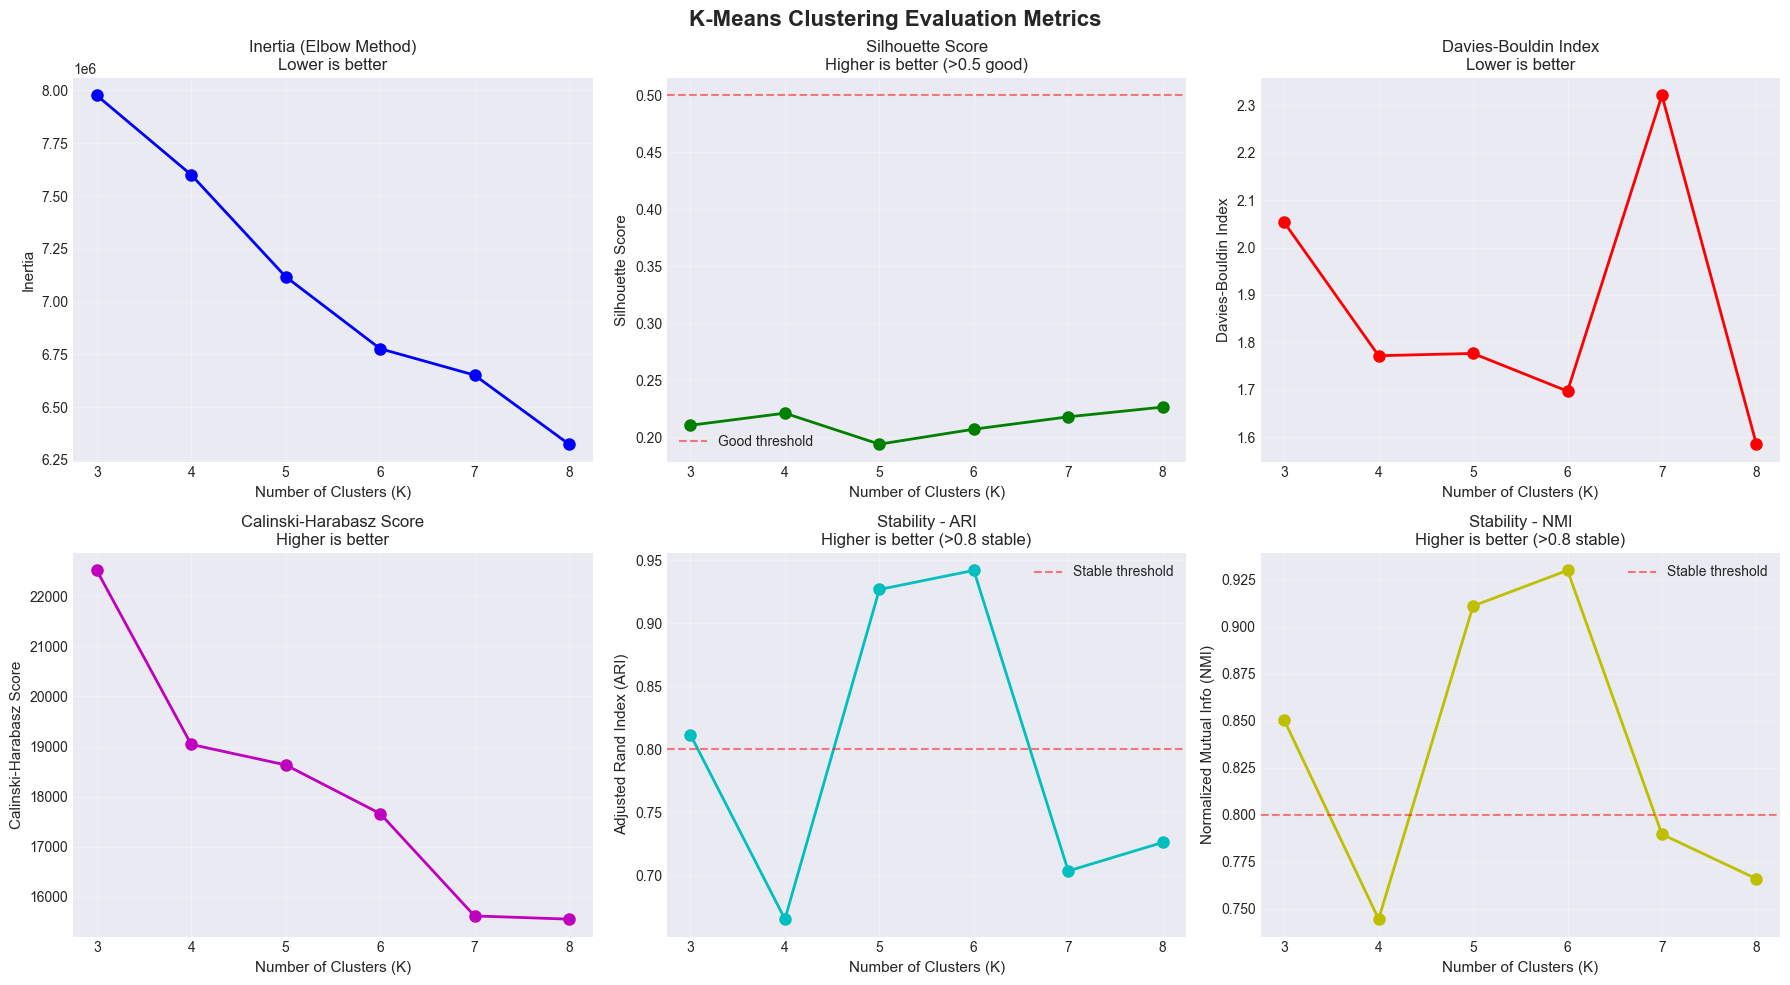

In [15]:
# Step 3.3: Visualize clustering metrics
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('K-Means Clustering Evaluation Metrics', fontsize=16, fontweight='bold')

# Plot 1: Inertia (Elbow Method)
axes[0, 0].plot(results_df['k'], results_df['inertia'], 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 0].set_ylabel('Inertia', fontsize=11)
axes[0, 0].set_title('Inertia (Elbow Method)\nLower is better', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(results_df['k'])

# Plot 2: Silhouette Score
axes[0, 1].plot(results_df['k'], results_df['silhouette'], 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11)
axes[0, 1].set_title('Silhouette Score\nHigher is better (>0.5 good)', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(results_df['k'])
axes[0, 1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold')
axes[0, 1].legend()

# Plot 3: Davies-Bouldin Index
axes[0, 2].plot(results_df['k'], results_df['davies_bouldin'], 'ro-', linewidth=2, markersize=8)
axes[0, 2].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[0, 2].set_ylabel('Davies-Bouldin Index', fontsize=11)
axes[0, 2].set_title('Davies-Bouldin Index\nLower is better', fontsize=12)
axes[0, 2].grid(True, alpha=0.3)
axes[0, 2].set_xticks(results_df['k'])

# Plot 4: Calinski-Harabasz Score
axes[1, 0].plot(results_df['k'], results_df['calinski_harabasz'], 'mo-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11)
axes[1, 0].set_title('Calinski-Harabasz Score\nHigher is better', fontsize=12)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(results_df['k'])

# Plot 5: Stability - ARI
axes[1, 1].plot(results_df['k'], results_df['stability_ari'], 'co-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 1].set_ylabel('Adjusted Rand Index (ARI)', fontsize=11)
axes[1, 1].set_title('Stability - ARI\nHigher is better (>0.8 stable)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(results_df['k'])
axes[1, 1].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Stable threshold')
axes[1, 1].legend()

# Plot 6: Stability - NMI
axes[1, 2].plot(results_df['k'], results_df['stability_nmi'], 'yo-', linewidth=2, markersize=8)
axes[1, 2].set_xlabel('Number of Clusters (K)', fontsize=11)
axes[1, 2].set_ylabel('Normalized Mutual Info (NMI)', fontsize=11)
axes[1, 2].set_title('Stability - NMI\nHigher is better (>0.8 stable)', fontsize=12)
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_xticks(results_df['k'])
axes[1, 2].axhline(y=0.8, color='r', linestyle='--', alpha=0.5, label='Stable threshold')
axes[1, 2].legend()

plt.tight_layout()
plt.show()

In [16]:
# Step 3.4: Check weighted segment sizes for business usability
print("Step 3.4: Analyzing segment sizes (population-weighted)...")
print("\nSegment sizes by K (using population weights):")

for k in K_range:
    labels = models[k].labels_
    
    # Calculate weighted segment sizes
    segment_sizes = []
    for cluster_id in range(k):
        cluster_mask = labels == cluster_id
        weighted_size = weights[cluster_mask].sum()
        total_weight = weights.sum()
        pct = (weighted_size / total_weight) * 100
        segment_sizes.append(pct)
    
    print(f"\nK = {k}:")
    for i, size in enumerate(segment_sizes):
        print(f"  Segment {i}: {size:.2f}%")
    
    min_size = min(segment_sizes)
    max_size = max(segment_sizes)
    print(f"  Range: {min_size:.2f}% - {max_size:.2f}%")
    
    if min_size < 3:
        print(f"  Warning: Very small segment detected (<3%)")
    elif min_size < 5:
        print(f"  Caution: Small segment detected (<5%)")
    else:
        print(f"  All segments are reasonably sized (>5%)")

Step 3.4: Analyzing segment sizes (population-weighted)...

Segment sizes by K (using population weights):

K = 3:
  Segment 0: 49.42%
  Segment 1: 44.18%
  Segment 2: 6.40%
  Range: 6.40% - 49.42%
  All segments are reasonably sized (>5%)

K = 4:
  Segment 0: 49.10%
  Segment 1: 5.73%
  Segment 2: 43.14%
  Segment 3: 2.03%
  Range: 2.03% - 49.10%

K = 5:
  Segment 0: 2.03%
  Segment 1: 42.91%
  Segment 2: 27.33%
  Segment 3: 22.01%
  Segment 4: 5.73%
  Range: 2.03% - 42.91%

K = 6:
  Segment 0: 3.62%
  Segment 1: 27.25%
  Segment 2: 40.27%
  Segment 3: 2.03%
  Segment 4: 21.24%
  Segment 5: 5.58%
  Range: 2.03% - 40.27%

K = 7:
  Segment 0: 3.60%
  Segment 1: 25.08%
  Segment 2: 5.55%
  Segment 3: 15.00%
  Segment 4: 21.35%
  Segment 5: 25.99%
  Segment 6: 3.43%
  Range: 3.43% - 25.99%
  Caution: Small segment detected (<5%)

K = 8:
  Segment 0: 38.27%
  Segment 1: 4.33%
  Segment 2: 24.65%
  Segment 3: 19.98%
  Segment 4: 3.54%
  Segment 5: 1.78%
  Segment 6: 5.42%
  Segment 7: 2.03%

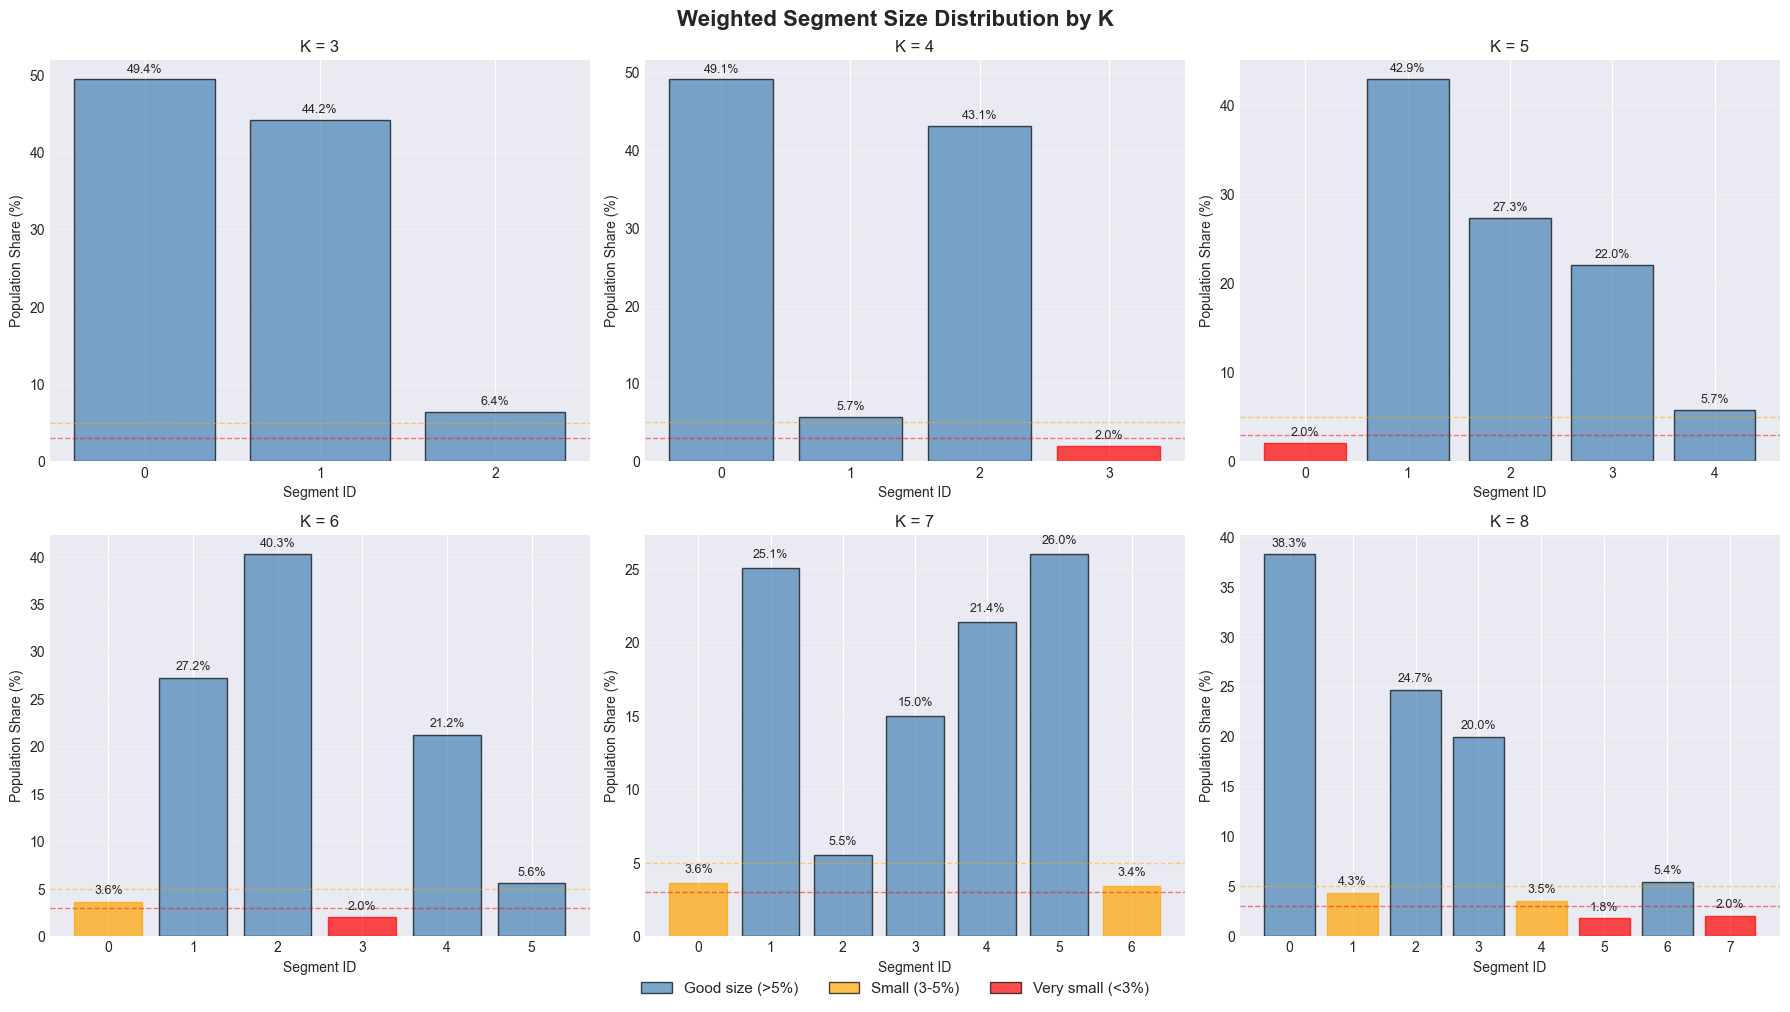

In [17]:
# Step 3.5: Visualize segment size distribution
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Weighted Segment Size Distribution by K', fontsize=16, fontweight='bold')

for idx, k in enumerate(K_range):
    row = idx // 3
    col = idx % 3
    
    labels = models[k].labels_
    
    # Calculate weighted segment sizes
    segment_sizes = []
    for cluster_id in range(k):
        cluster_mask = labels == cluster_id
        weighted_size = weights[cluster_mask].sum()
        total_weight = weights.sum()
        pct = (weighted_size / total_weight) * 100
        segment_sizes.append(pct)
    
    bars = axes[row, col].bar(range(k), segment_sizes, color='steelblue', alpha=0.7, edgecolor='black')
    
    for i, (bar, size) in enumerate(zip(bars, segment_sizes)):
        if size < 5:
            bar.set_color('orange')
        if size < 3:
            bar.set_color('red')
    
    axes[row, col].set_xlabel('Segment ID', fontsize=10)
    axes[row, col].set_ylabel('Population Share (%)', fontsize=10)
    axes[row, col].set_title(f'K = {k}', fontsize=12)
    axes[row, col].set_xticks(range(k))
    axes[row, col].grid(True, alpha=0.3, axis='y')
    axes[row, col].axhline(y=5, color='orange', linestyle='--', alpha=0.5, linewidth=1)
    axes[row, col].axhline(y=3, color='red', linestyle='--', alpha=0.5, linewidth=1)
    
    for i, size in enumerate(segment_sizes):
        axes[row, col].text(i, size + 0.5, f'{size:.1f}%', ha='center', va='bottom', fontsize=9)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, edgecolor='black', label='Good size (>5%)'),
    Patch(facecolor='orange', alpha=0.7, edgecolor='black', label='Small (3-5%)'),
    Patch(facecolor='red', alpha=0.7, edgecolor='black', label='Very small (<3%)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=3, fontsize=11, bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()

## Step 4: Select Optimal K and Fit Final Model

Based on the metrics and business considerations above, we chose the optimal K value as 6. Might have to converge two similar clusters.

Selected K=6 because it provides a strong balance of cluster quality (high silhouette, low Davies–Bouldin), high stability (ARI/NMI > 0.9), and practical interpretability for marketing personas, while avoiding the over-fragmentation seen at higher K.

We merged because, based on the survey population weights, one cluster represented only ~2.03% of the weighted population (below our 3% minimum segment threshold), making it too small and unstable to treat as a standalone marketing segment.



In [18]:
# Step 4.1: Choose optimal K
# Based on your analysis, set the optimal K value
OPTIMAL_K = 6 

print(f"Selected optimal K = {OPTIMAL_K}")
print("\nUsing the model trained with this K value...")

final_model = models[OPTIMAL_K]
final_labels = final_model.labels_

df_work['cluster_id'] = final_labels

print(f"\nFinal model statistics:")
print(f"  Number of clusters: {OPTIMAL_K}")
print(f"  Inertia: {final_model.inertia_:,.0f}")
print(f"  Iterations: {final_model.n_iter_}")

print(f"\nWeighted segment sizes:")
for cluster_id in range(OPTIMAL_K):
    cluster_mask = final_labels == cluster_id
    weighted_size = weights[cluster_mask].sum()
    total_weight = weights.sum()
    pct = (weighted_size / total_weight) * 100
    raw_count = cluster_mask.sum()
    print(f"  Segment {cluster_id}: {pct:.2f}% (n={raw_count:,})")

Selected optimal K = 6

Using the model trained with this K value...

Final model statistics:
  Number of clusters: 6
  Inertia: 6,776,848
  Iterations: 9

Weighted segment sizes:
  Segment 0: 3.62% (n=7,205)
  Segment 1: 27.25% (n=56,178)
  Segment 2: 40.27% (n=78,870)
  Segment 3: 2.03% (n=3,906)
  Segment 4: 21.24% (n=42,604)
  Segment 5: 5.58% (n=10,760)


In [19]:
# Step 4.2: Check for micro-segments and optionally merge
print("Step 4.2: Checking for micro-segments (<3% population)...")

segment_info = []
for cluster_id in range(OPTIMAL_K):
    cluster_mask = final_labels == cluster_id
    weighted_size = weights[cluster_mask].sum()
    total_weight = weights.sum()
    pct = (weighted_size / total_weight) * 100
    segment_info.append({
        'cluster_id': cluster_id,
        'weighted_pct': pct,
        'count': cluster_mask.sum()
    })

segment_df = pd.DataFrame(segment_info).sort_values('weighted_pct', ascending=False)
print("\nSegment sizes (sorted by population %):")
print(segment_df.to_string(index=False))

# Identify micro-segments
micro_segments = segment_df[segment_df['weighted_pct'] < 3.0]['cluster_id'].tolist()

segment_summary = segment_df.copy()

Step 4.2: Checking for micro-segments (<3% population)...

Segment sizes (sorted by population %):
 cluster_id  weighted_pct  count
          2     40.273436  78870
          1     27.248322  56178
          4     21.243542  42604
          5      5.584493  10760
          0      3.623764   7205
          3      2.026443   3906


In [20]:
# Step 4.3: Merge micro-segments if needed
print("\nStep 4.3: Handling micro-segments by merging into nearest clusters...")

if len(micro_segments) > 0:
    print(f"Merging {len(micro_segments)} micro-segment(s)...")
    
    df_work['final_segment_id'] = df_work['cluster_id'].copy()
    
    # Get cluster centroids from the model
    centroids = final_model.cluster_centers_
    
    # For each micro-segment, find nearest large segment
    for micro_seg in micro_segments:
        micro_centroid = centroids[micro_seg]
    
        # Find nearest centroid among non-micro segments
        large_segments = [s for s in range(OPTIMAL_K) if s not in micro_segments]
        min_distance = float('inf')
        nearest_segment = None
        
        for large_seg in large_segments:
            distance = np.linalg.norm(micro_centroid - centroids[large_seg])
            if distance < min_distance:
                min_distance = distance
                nearest_segment = large_seg
        
        # Merge micro-segment into nearest large segment
        mask = df_work['cluster_id'] == micro_seg
        df_work.loc[mask, 'final_segment_id'] = nearest_segment
        
        print(f"  Merged segment {micro_seg} ({segment_df.loc[segment_df['cluster_id']==micro_seg, 'weighted_pct'].values[0]:.2f}%) "
              f"into segment {nearest_segment} (distance: {min_distance:.2f})")
    
    final_segment_info = []
    unique_final_segments = sorted(df_work['final_segment_id'].unique())
    
    for seg_id in unique_final_segments:
        seg_mask = df_work['final_segment_id'] == seg_id
        seg_weights = weights[seg_mask]
        weighted_size = seg_weights.sum()
        total_weight = weights.sum()
        pct = (weighted_size / total_weight) * 100
        final_segment_info.append({
            'final_segment_id': seg_id,
            'weighted_pct': pct,
            'count': seg_mask.sum()
        })
    
    final_segment_df = pd.DataFrame(final_segment_info).sort_values('weighted_pct', ascending=False)
    
    print(f"\nFinal segment sizes after merging:")
    print(final_segment_df.to_string(index=False))
    print(f"\nReduced from {OPTIMAL_K} to {len(unique_final_segments)} actionable segments")
    
    FINAL_K = len(unique_final_segments)
else:
    print("No micro-segments to merge. Using original cluster assignments.")
    df_work['final_segment_id'] = df_work['cluster_id'].copy()
    final_segment_df = segment_df.copy()
    final_segment_df.rename(columns={'cluster_id': 'final_segment_id'}, inplace=True)
    FINAL_K = OPTIMAL_K

print(f"\nFinal number of segments: {FINAL_K}")


Step 4.3: Handling micro-segments by merging into nearest clusters...
Merging 1 micro-segment(s)...
  Merged segment 3 (2.03%) into segment 2 (distance: 10.27)

Final segment sizes after merging:
 final_segment_id  weighted_pct  count
                2     42.299879  82776
                1     27.248322  56178
                4     21.243542  42604
                5      5.584493  10760
                0      3.623764   7205

Reduced from 6 to 5 actionable segments

Final number of segments: 5



Step 4.4: Creating before/after merge visualization...


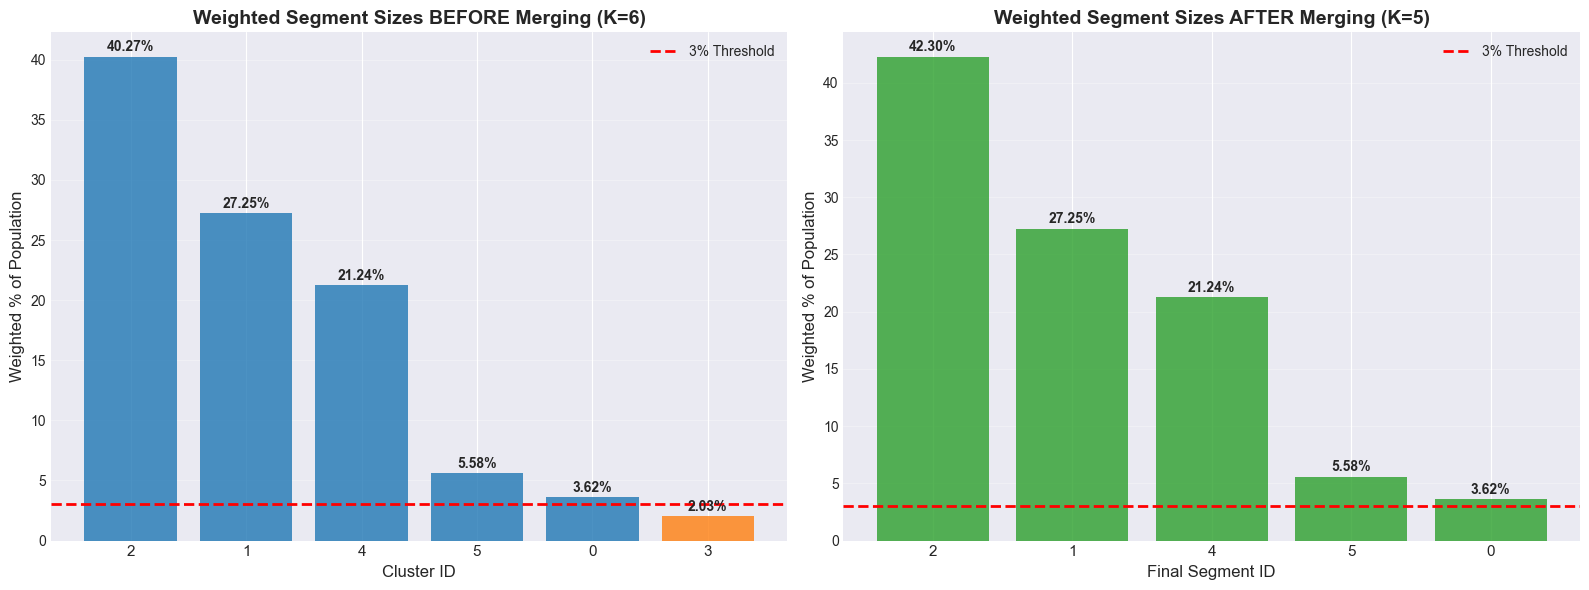

In [21]:
# Step 4.4: Visualize segment sizes before and after merging
print("\nStep 4.4: Creating before/after merge visualization...")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Before merging
ax1 = axes[0]
before_sorted = segment_df.sort_values('weighted_pct', ascending=False)
colors_before = ['#1f77b4' if idx not in micro_segments else '#ff7f0e' 
                 for idx in before_sorted['cluster_id']]
bars1 = ax1.bar(range(len(before_sorted)), before_sorted['weighted_pct'], color=colors_before, alpha=0.8)
ax1.set_xlabel('Cluster ID', fontsize=12)
ax1.set_ylabel('Weighted % of Population', fontsize=12)
ax1.set_title(f'Weighted Segment Sizes BEFORE Merging (K={OPTIMAL_K})', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(before_sorted)))
ax1.set_xticklabels(before_sorted['cluster_id'], fontsize=11)
ax1.axhline(y=3, color='red', linestyle='--', linewidth=2, label='3% Threshold')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars1, before_sorted['weighted_pct'])):
    ax1.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.2f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# After merging
ax2 = axes[1]
after_sorted = final_segment_df.sort_values('weighted_pct', ascending=False)
colors_after = ['#2ca02c'] * len(after_sorted)  # All green for actionable segments
bars2 = ax2.bar(range(len(after_sorted)), after_sorted['weighted_pct'], color=colors_after, alpha=0.8)
ax2.set_xlabel('Final Segment ID', fontsize=12)
ax2.set_ylabel('Weighted % of Population', fontsize=12)
ax2.set_title(f'Weighted Segment Sizes AFTER Merging (K={FINAL_K})', fontsize=14, fontweight='bold')
ax2.set_xticks(range(len(after_sorted)))
ax2.set_xticklabels(after_sorted['final_segment_id'].astype(int), fontsize=11)
ax2.axhline(y=3, color='red', linestyle='--', linewidth=2, label='3% Threshold')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, after_sorted['weighted_pct'])):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.2, f'{val:.2f}%', 
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()


Step 4.5: Creating 2D cluster visualization...
Applying PCA to reduce to 49 components...
Explained variance by first 49 components: 1.0000
UMAP not available, using t-SNE instead...


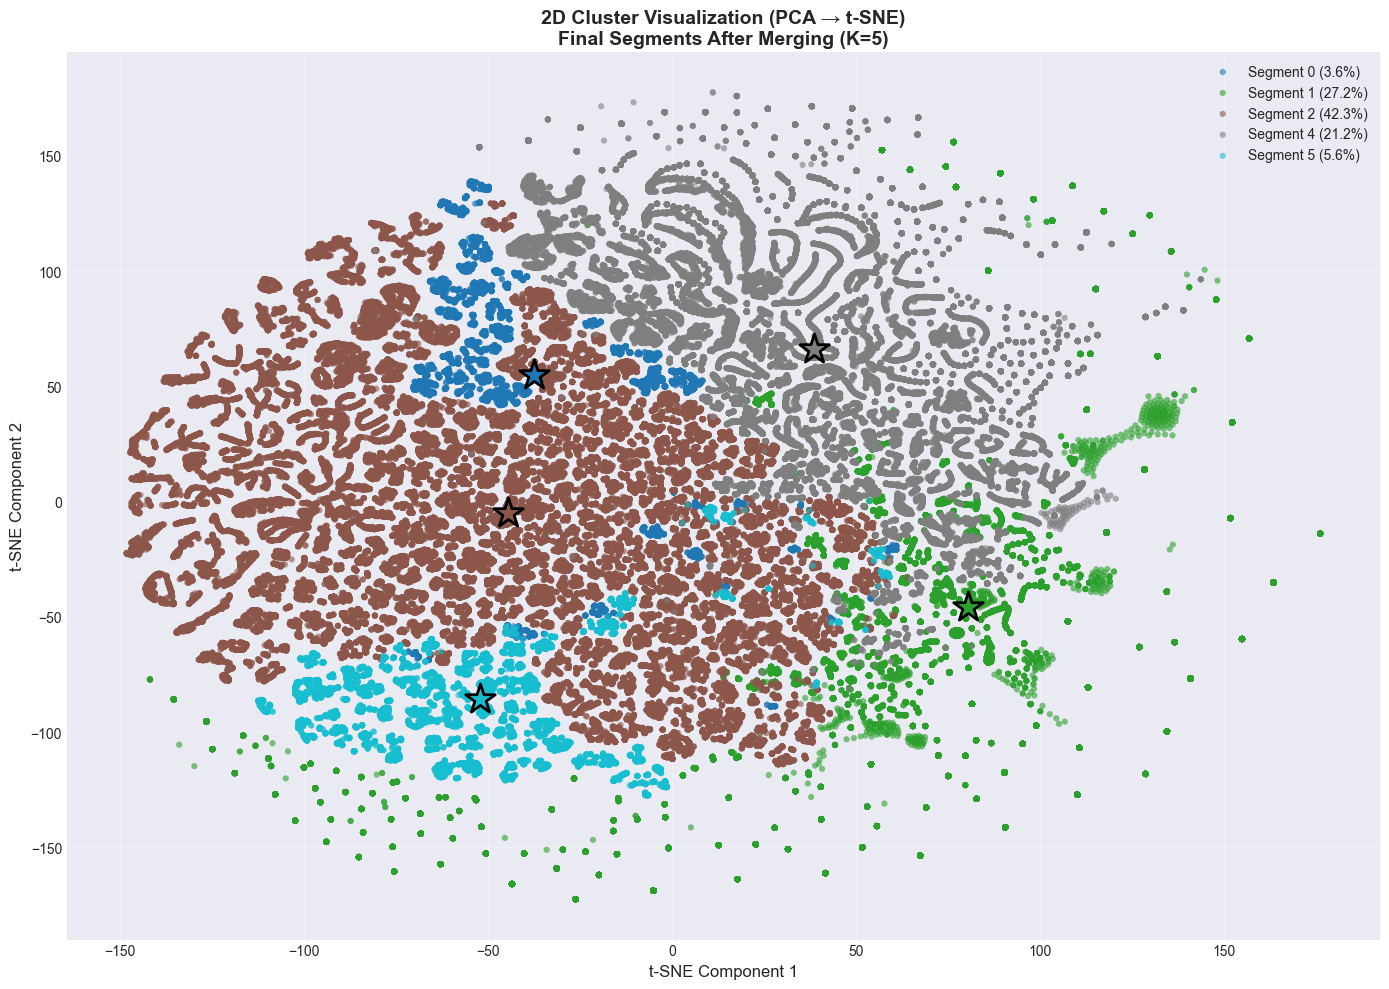

In [22]:
# Step 4.5: Create 2D cluster visualization
print("\nStep 4.5: Creating 2D cluster visualization...")

# First, perform dimensionality reduction using PCA to 50 components
from sklearn.decomposition import PCA

n_components_pca = min(50, X_scaled.shape[1])
print(f"Applying PCA to reduce to {n_components_pca} components...")
pca = PCA(n_components=n_components_pca, random_state=42)
X_pca = pca.fit_transform(X_scaled)
print(f"Explained variance by first {n_components_pca} components: {pca.explained_variance_ratio_.sum():.4f}")

# Then apply UMAP for 2D visualization
try:
    import umap
    print("Applying UMAP for 2D projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    X_2d = reducer.fit_transform(X_pca)
    method_name = "UMAP"
except ImportError:
    print("UMAP not available, using t-SNE instead...")
    from sklearn.manifold import TSNE
    reducer = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    X_2d = reducer.fit_transform(X_pca)
    method_name = "t-SNE"

fig, ax = plt.subplots(figsize=(14, 10))

colors = plt.cm.tab10(np.linspace(0, 1, FINAL_K))
segment_colors = {seg_id: colors[i] for i, seg_id in enumerate(sorted(df_work['final_segment_id'].unique()))}

for seg_id in sorted(df_work['final_segment_id'].unique()):
    mask = df_work['final_segment_id'] == seg_id
    seg_pct = final_segment_df[final_segment_df['final_segment_id'] == seg_id]['weighted_pct'].values[0]
    ax.scatter(X_2d[mask, 0], X_2d[mask, 1], 
               c=[segment_colors[seg_id]], 
               label=f'Segment {seg_id} ({seg_pct:.1f}%)',
               alpha=0.6, s=20, edgecolors='none')
    
for seg_id in sorted(df_work['final_segment_id'].unique()):
    mask = df_work['final_segment_id'] == seg_id
    centroid_2d = X_2d[mask].mean(axis=0)
    ax.scatter(centroid_2d[0], centroid_2d[1], 
               c=[segment_colors[seg_id]], 
               s=500, marker='*', edgecolors='black', linewidths=2,
               zorder=10)

ax.set_xlabel(f'{method_name} Component 1', fontsize=12)
ax.set_ylabel(f'{method_name} Component 2', fontsize=12)
ax.set_title(f'2D Cluster Visualization (PCA → {method_name})\nFinal Segments After Merging (K={FINAL_K})', 
             fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Step 5: Profile Segments with Weighted Statistics

Now we'll create detailed profiles for each segment using population-weighted statistics.

- Population concentration: The market is dominated by three segments — Segment 2 (42.3%), Segment 1 (27.2%), and Segment 4 (21.2%) (~91% combined), so most people are either mainstream workers, dependents/children, or older low-attachment individuals.

- Income opportunity is uneven: High-income likelihood is concentrated in a small niche (Segment 0: 3.6% size but ~33.6% >50K) and a large moderate-opportunity group (Segment 2: 42.3% size, ~10.9% >50K).

- Workforce attachment is the main separator: Segments 2 & 5 work ~44–45 weeks/year (active workforce), while 1 & 4 have near-zero weeks (dependents/retired/not in labor force).

- Distinct sub-persona via union: Segment 5 stands out with high union membership (~17%), making it a meaningful actionable persona even if income lift is modest.

In [23]:
# Step 5.1: Create weighted profiling functions
def weighted_mean(values, weights):
    """Calculate weighted mean"""
    return np.average(values, weights=weights)

def weighted_median(values, weights):
    """Calculate weighted median"""
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_weights = weights[sorted_indices]
    cumsum = np.cumsum(sorted_weights)
    cutoff = sorted_weights.sum() / 2.0
    return sorted_values[np.searchsorted(cumsum, cutoff)]

def weighted_mode(series, weights):
    """Calculate weighted mode (most common value by weight)"""
    weighted_counts = series.groupby(series).apply(lambda x: weights[x.index].sum())
    return weighted_counts.idxmax()

def weighted_proportion(series, weights, value):
    """Calculate weighted proportion of a specific value"""
    mask = series == value
    return weights[mask].sum() / weights.sum()

In [24]:
# Step 5.2: Profile demographic characteristics (weighted)
print("Step 5.2: Profiling demographic characteristics by segment...\n")

demographic_profiles = []

for cluster_id in sorted(df_work['final_segment_id'].unique()):
    cluster_mask = df_work['final_segment_id'] == cluster_id
    cluster_weights = weights[cluster_mask]
    
    profile = {
        'Segment': cluster_id,
        'Population %': (cluster_weights.sum() / weights.sum()) * 100,
    }
    
    # Age statistics (ensure numeric)
    age_values = pd.to_numeric(df_work.loc[cluster_mask, 'age'], errors='coerce').fillna(0).values
    profile['Avg Age'] = weighted_mean(age_values, cluster_weights)
    profile['Median Age'] = weighted_median(age_values, cluster_weights)
    
    # Family members under 18 (ensure numeric)
    children_values = pd.to_numeric(df_work.loc[cluster_mask, 'family members under 18'], errors='coerce').fillna(0).values
    profile['Avg Children'] = weighted_mean(children_values, cluster_weights)
    
    # Most common education (weighted mode) - use reset_index to align indices
    education_series = df_work.loc[cluster_mask, 'education'].reset_index(drop=True)
    education_weights = pd.Series(cluster_weights, index=education_series.index)
    weighted_counts = education_series.groupby(education_series).apply(lambda x: education_weights.loc[x.index].sum())
    profile['Top Education'] = weighted_counts.idxmax()
    
    # Most common marital status
    marital_series = df_work.loc[cluster_mask, 'marital stat'].reset_index(drop=True)
    marital_weights = pd.Series(cluster_weights, index=marital_series.index)
    weighted_counts = marital_series.groupby(marital_series).apply(lambda x: marital_weights.loc[x.index].sum())
    profile['Top Marital Status'] = weighted_counts.idxmax()
    
    # Student enrollment
    enrolled = df_work.loc[cluster_mask, 'enroll in edu inst last wk'].reset_index(drop=True)
    enrolled_weights = pd.Series(cluster_weights, index=enrolled.index)
    enrolled_mask = enrolled == 'College or university'
    profile['% Enrolled'] = (enrolled_weights[enrolled_mask].sum() / enrolled_weights.sum()) * 100
    
    demographic_profiles.append(profile)

demo_profile_df = pd.DataFrame(demographic_profiles)
print("Demographic Profiles (Weighted):\n")

print(demo_profile_df.to_string(index=False))


Step 5.2: Profiling demographic characteristics by segment...

Demographic Profiles (Weighted):

 Segment  Population %   Avg Age  Median Age  Avg Children        Top Education              Top Marital Status  % Enrolled
       0      3.623764 48.564867          46           0.0 High school graduate Married-civilian spouse present    1.369630
       1     27.248322  8.716175           8           0.0             Children                   Never married    1.947252
       2     42.299879 38.467825          37           0.0 High school graduate Married-civilian spouse present    3.663240
       4     21.243542 56.733043          62           0.0 High school graduate Married-civilian spouse present    2.777192
       5      5.584493 36.079223          35           0.0 High school graduate Married-civilian spouse present    6.318975


In [25]:
# Step 5.3: Profile economic/employment characteristics (weighted)
print("Step 5.3: Profiling economic/employment characteristics by segment...\n")

economic_profiles = []

for cluster_id in sorted(df_work['final_segment_id'].unique()):
    cluster_mask = df_work['final_segment_id'] == cluster_id
    cluster_weights = weights[cluster_mask]
    
    profile = {
        'Segment': cluster_id,
    }
    
    # Weeks worked (ensure numeric)
    weeks_values = pd.to_numeric(df_work.loc[cluster_mask, 'weeks worked in year'], errors='coerce').fillna(0).values
    profile['Avg Weeks Worked'] = weighted_mean(weeks_values, cluster_weights)
    
    # Top occupation (weighted mode with index alignment)
    occupation_series = df_work.loc[cluster_mask, 'major occupation code'].reset_index(drop=True)
    occupation_weights = pd.Series(cluster_weights, index=occupation_series.index)
    weighted_counts = occupation_series.groupby(occupation_series).apply(lambda x: occupation_weights.loc[x.index].sum())
    profile['Top Occupation'] = weighted_counts.idxmax()
    
    # Top industry
    industry_series = df_work.loc[cluster_mask, 'major industry code'].reset_index(drop=True)
    industry_weights = pd.Series(cluster_weights, index=industry_series.index)
    weighted_counts = industry_series.groupby(industry_series).apply(lambda x: industry_weights.loc[x.index].sum())
    profile['Top Industry'] = weighted_counts.idxmax()
    
    # Class of worker
    class_series = df_work.loc[cluster_mask, 'class of worker'].reset_index(drop=True)
    class_weights = pd.Series(cluster_weights, index=class_series.index)
    weighted_counts = class_series.groupby(class_series).apply(lambda x: class_weights.loc[x.index].sum())
    profile['Top Class of Worker'] = weighted_counts.idxmax()
    
    # Employment status
    emp_series = df_work.loc[cluster_mask, 'full or part time employment stat'].reset_index(drop=True)
    emp_weights = pd.Series(cluster_weights, index=emp_series.index)
    weighted_counts = emp_series.groupby(emp_series).apply(lambda x: emp_weights.loc[x.index].sum())
    profile['Top Employment Status'] = weighted_counts.idxmax()
    
    # Self-employed percentage (weighted)
    self_emp = pd.to_numeric(df_work.loc[cluster_mask, 'own business or self employed'], errors='coerce').fillna(0).reset_index(drop=True)
    self_emp_weights = pd.Series(cluster_weights, index=self_emp.index)
    self_emp_mask = self_emp > 0
    profile['% Self-Employed'] = (self_emp_weights[self_emp_mask].sum() / self_emp_weights.sum()) * 100
    
    # Union membership (weighted)
    union = df_work.loc[cluster_mask, 'member of a labor union'].reset_index(drop=True)
    union_weights = pd.Series(cluster_weights, index=union.index)
    union_mask = union == 'Yes'
    profile['% Union Member'] = (union_weights[union_mask].sum() / union_weights.sum()) * 100
    
    economic_profiles.append(profile)

econ_profile_df = pd.DataFrame(economic_profiles)
print("Economic/Employment Profiles (Weighted):\n")
print(econ_profile_df.to_string(index=False))

Step 5.3: Profiling economic/employment characteristics by segment...

Economic/Employment Profiles (Weighted):

 Segment  Avg Weeks Worked                 Top Occupation                Top Industry Top Class of Worker    Top Employment Status  % Self-Employed  % Union Member
       0         39.189231                Not in universe Not in universe or children             Private Children or Armed Forces        14.306954        1.436971
       1          0.570514                Not in universe Not in universe or children     Not in universe Children or Armed Forces         0.502884        0.000000
       2         44.329342 Adm support including clerical                Retail trade             Private Children or Armed Forces        17.823434        1.213906
       4          3.532159                Not in universe Not in universe or children     Not in universe       Not in labor force         1.730735        0.000000
       5         44.861309 Adm support including clerical          

In [26]:
# Step 5.4: Profile income characteristics (weighted) - for interpretation only
print("Step 5.4: Profiling income characteristics by segment (for interpretation only)...\n")

income_profiles = []

for cluster_id in sorted(df_work['final_segment_id'].unique()):
    cluster_mask = df_work['final_segment_id'] == cluster_id
    cluster_weights = weights[cluster_mask]
    
    profile = {
        'Segment': cluster_id,
    }
    
    # Income label (>50K) - weighted proportion
    income_high = df_work.loc[cluster_mask, 'label'] == '50000+.'
    profile['% Income >50K'] = (cluster_weights[income_high.values].sum() / cluster_weights.sum()) * 100
    
    # Financial income sources
    profile['% Has Wage'] = (df_work.loc[cluster_mask, 'has_wage_per_hour'].values * cluster_weights).sum() / cluster_weights.sum() * 100
    profile['% Has Capital Gains'] = (df_work.loc[cluster_mask, 'has_capital_gains'].values * cluster_weights).sum() / cluster_weights.sum() * 100
    profile['% Has Dividends'] = (df_work.loc[cluster_mask, 'has_dividends_from_stocks'].values * cluster_weights).sum() / cluster_weights.sum() * 100
    
    # Average log-transformed income sources (for those who have them)
    wage_mask = df_work.loc[cluster_mask, 'has_wage_per_hour'] > 0
    if wage_mask.sum() > 0:
        profile['Avg Log Wage'] = weighted_mean(
            df_work.loc[cluster_mask, 'log_wage_per_hour'].values[wage_mask.values],
            cluster_weights[wage_mask.values]
        )
    else:
        profile['Avg Log Wage'] = 0.0
    
    income_profiles.append(profile)

income_profile_df = pd.DataFrame(income_profiles)
print(income_profile_df.to_string(index=False))

Step 5.4: Profiling income characteristics by segment (for interpretation only)...

 Segment  % Income >50K  % Has Wage  % Has Capital Gains  % Has Dividends  Avg Log Wage
       0      33.602126    4.071080           100.000000        28.724528      6.918812
       1       0.010319    0.000000             0.000000         0.168156      0.000000
       2      10.927953    0.319735             0.000000        14.607059      6.902195
       4       1.530508    0.000000             0.000000        13.454028      0.000000
       5       4.242525  100.000000             1.654551         9.840853      6.732098



Step 5.5: Creating weighted income >$50K by segment visualization...


NameError: name 'segment_short_labels' is not defined

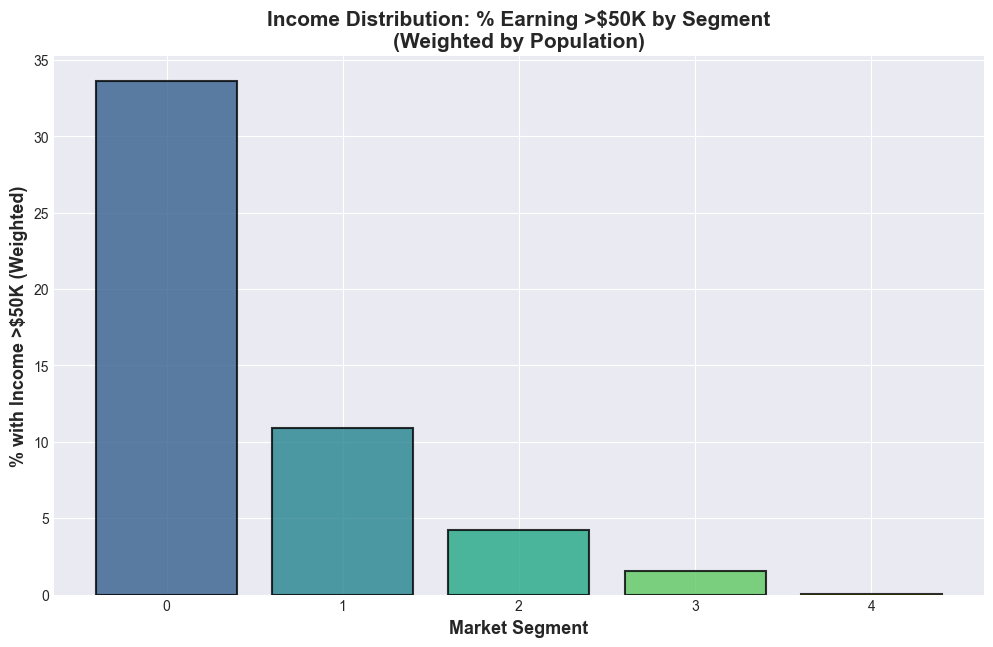

In [27]:
# Step 5.5: Visualize weighted income >$50K by segment
print("\nStep 5.5: Creating weighted income >$50K by segment visualization...")

fig, ax = plt.subplots(figsize=(12, 7))

income_over_50k = [profile['% Income >50K'] for profile in income_profiles]
segment_ids = [profile['Segment'] for profile in income_profiles]

sorted_indices = np.argsort(income_over_50k)[::-1]
sorted_segments = [segment_ids[i] for i in sorted_indices]
sorted_income = [income_over_50k[i] for i in sorted_indices]

colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_segments)))
bars = ax.bar(range(len(sorted_segments)), sorted_income, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xlabel('Market Segment', fontsize=13, fontweight='bold')
ax.set_ylabel('% with Income >$50K (Weighted)', fontsize=13, fontweight='bold')
ax.set_title('Income Distribution: % Earning >$50K by Segment\n(Weighted by Population)', 
             fontsize=15, fontweight='bold')
ax.set_xticks(range(len(sorted_segments)))
ax.set_xticklabels([segment_short_labels[int(s)] for s in sorted_segments], fontsize=10, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max(sorted_income) * 1.15)

for i, (bar, val) in enumerate(zip(bars, sorted_income)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.5, f'{val:.1f}%', 
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


Step 5.6: Creating weighted segment market share visualization...


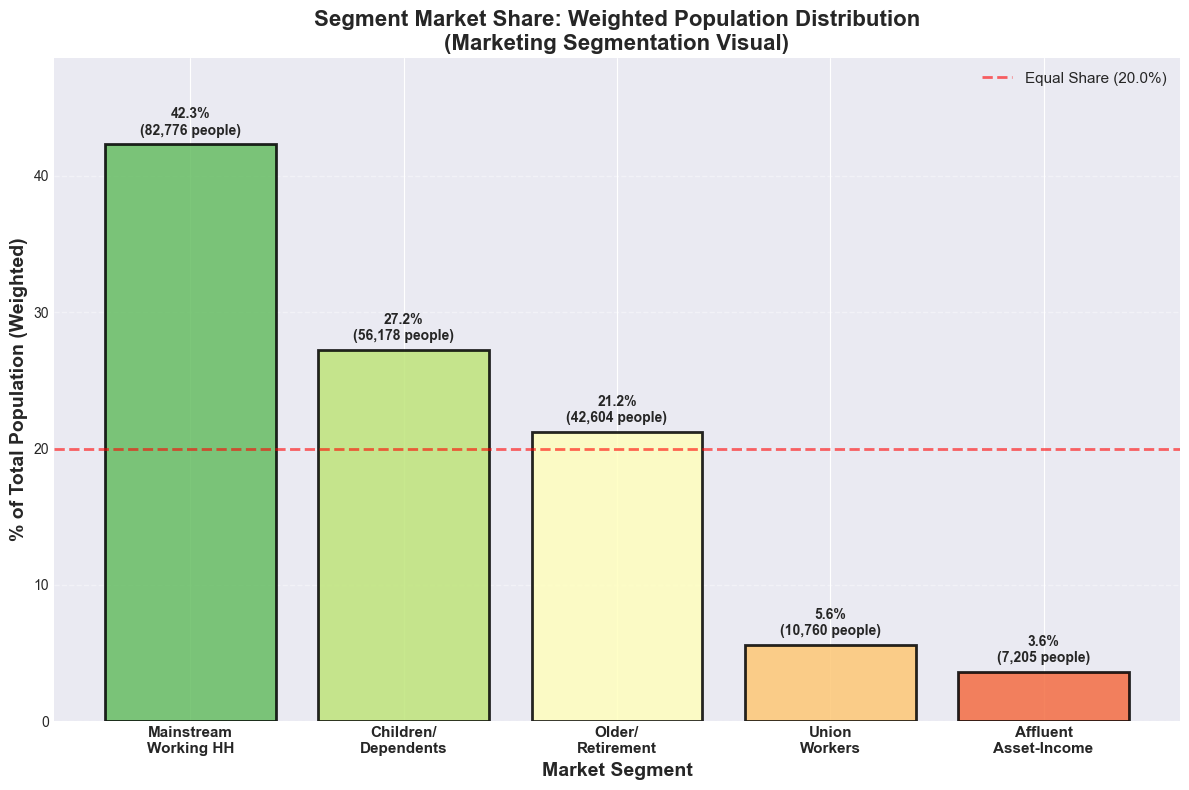

In [ ]:
# Step 5.6: Visualize weighted segment market share
print("\nStep 5.6: Creating weighted segment market share visualization...")

fig, ax = plt.subplots(figsize=(12, 8))

segment_pcts = final_segment_df['weighted_pct'].values
segment_ids = final_segment_df['final_segment_id'].values

sorted_indices = np.argsort(segment_pcts)[::-1]
sorted_segments = segment_ids[sorted_indices]
sorted_pcts = segment_pcts[sorted_indices]

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(sorted_segments)))
bars = ax.bar(range(len(sorted_segments)), sorted_pcts, color=colors, alpha=0.85, edgecolor='black', linewidth=2)

ax.set_xlabel('Market Segment', fontsize=14, fontweight='bold')
ax.set_ylabel('% of Total Population (Weighted)', fontsize=14, fontweight='bold')
ax.set_title('Segment Market Share: Weighted Population Distribution\n(Marketing Segmentation Visual)', 
             fontsize=16, fontweight='bold')
ax.set_xticks(range(len(sorted_segments)))
ax.set_xticklabels([segment_short_labels[int(s)] for s in sorted_segments], fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1)
ax.set_ylim(0, max(sorted_pcts) * 1.15)

for i, (bar, pct, seg_id) in enumerate(zip(bars, sorted_pcts, sorted_segments)):
    count = final_segment_df[final_segment_df['final_segment_id'] == seg_id]['count'].values[0]
    ax.text(bar.get_x() + bar.get_width()/2, pct + 0.5, 
            f'{pct:.1f}%\n({count:,} people)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

equal_share = 100.0 / len(sorted_segments)
ax.axhline(y=equal_share, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label=f'Equal Share ({equal_share:.1f}%)')
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()

## Step 6: Create Marketing Segment Cards

Segment cards (based on the profiling results)

Segment 2 – “Mainstream Working Households (Retail/Admin Core)”
Largest group (42.3%); ~44 weeks worked; top occupation admin/clerical + retail; moderate >50K (~10.9%) → biggest volume target.

Segment 1 – “Children | Dependents (Under-18 Population)”
Avg age ~9; near-zero work; occupation/industry “not in universe”; ~0% >50K → exclude from income-based targeting.

Segment 4 – “Older | Retirement-Age, Low Workforce Attachment”
Older (median ~62); very low weeks worked; “not in labor force”; low >50K (~1.5%) → low priority for premium targeting.

Segment 5 – “Union-Connected Hourly Workers (Full-Time Retail/Admin)”
Smaller (5.6%); full-time work (~45 weeks); retail/admin core; very high union membership (~17%) → tailored messaging/benefits-based targeting.

Segment 0 – “Affluent Asset-Income Households (High-Income Niche)”
Small (3.6%) but highest >50K (~33.6%); strong asset-income signal (capital gains/dividends) → premium/high-ROI segment.

Step 6.1: Creating marketing segment names and cards...

Market Segments Overview:
 Segment ID                                            Segment Name  Market Share %   Avg Age        Top Education              Top Marital Status  Avg Weeks Worked                 Top Occupation                Top Industry  % Income >50K  % Self-Employed  % Union Member
          0    Affluent Asset-Income Households (High-Income Niche)        3.623764 48.564867 High school graduate Married-civilian spouse present         39.189231                Not in universe Not in universe or children      33.602126        14.306954        1.436971
          1             Children | Dependents (Under-18 Population)       27.248322  8.716175             Children                   Never married          0.570514                Not in universe Not in universe or children       0.010319         0.502884        0.000000
          2       Mainstream Working Households (Retail/Admin Core)       42.299879 38.467825 High sc

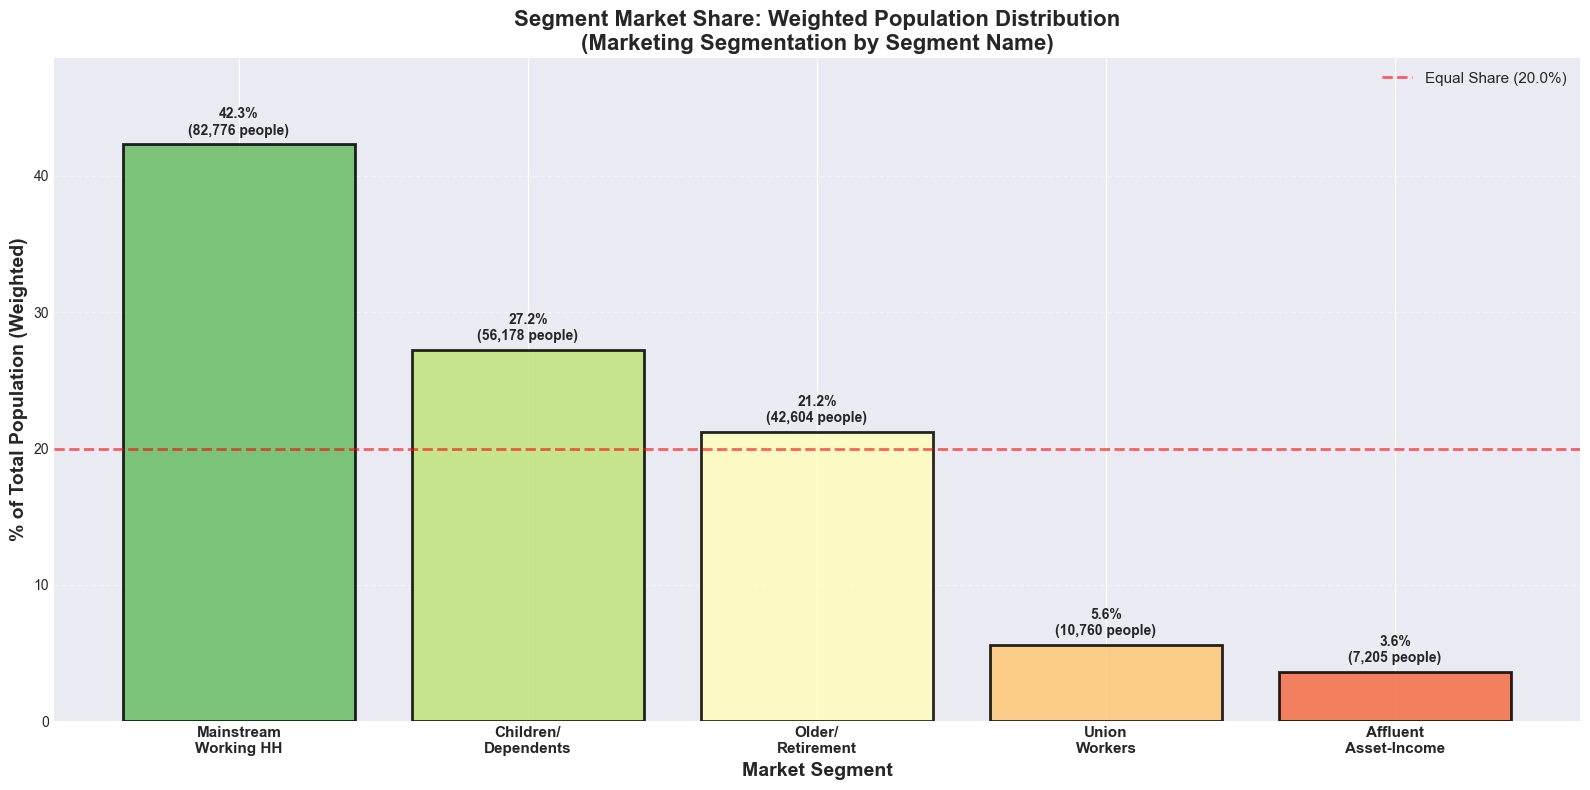

In [ ]:
# Step 6.1: Define segment names based on profiles
print("Step 6.1: Creating marketing segment names and cards...\n")

segment_name_map = {
    2: "Mainstream Working Households (Retail/Admin Core)",
    1: "Children | Dependents (Under-18 Population)",
    4: "Older | Retirement-Age, Low Workforce Attachment",
    5: "Union-Connected Hourly Workers (Full-Time Retail/Admin)",
    0: "Affluent Asset-Income Households (High-Income Niche)"
}

# Shorter labels for visualizations
segment_short_labels = {
    0: "Affluent\nAsset-Income",
    1: "Children/\nDependents",
    2: "Mainstream\nWorking HH",
    4: "Older/\nRetirement",
    5: "Union\nWorkers"
}

segment_cards = []

for seg_id in sorted(df_work['final_segment_id'].unique()):

    demo_row = demo_profile_df[demo_profile_df['Segment'] == seg_id].iloc[0]
    econ_row = econ_profile_df[econ_profile_df['Segment'] == seg_id].iloc[0]
    income_row = income_profile_df[income_profile_df['Segment'] == seg_id].iloc[0]
    
    card = {
        'Segment ID': seg_id,
        'Segment Name': segment_name_map[seg_id],
        'Market Share %': demo_row['Population %'],
        'Avg Age': demo_row['Avg Age'],
        'Top Education': demo_row['Top Education'],
        'Top Marital Status': demo_row['Top Marital Status'],
        'Avg Weeks Worked': econ_row['Avg Weeks Worked'],
        'Top Occupation': econ_row['Top Occupation'],
        'Top Industry': econ_row['Top Industry'],
        '% Income >50K': income_row['% Income >50K'],
        '% Self-Employed': econ_row['% Self-Employed'],
        '% Union Member': econ_row['% Union Member']
    }
    
    segment_cards.append(card)

segment_cards_df = pd.DataFrame(segment_cards)

print("Market Segments Overview:")
print(segment_cards_df.to_string(index=False))

print("\nCreating market share visualization with segment names...")

fig, ax = plt.subplots(figsize=(16, 8))

segment_cards_df_sorted = segment_cards_df.sort_values('Market Share %', ascending=False)

segment_pcts = segment_cards_df_sorted['Market Share %'].values
segment_names = segment_cards_df_sorted['Segment Name'].values
segment_ids = segment_cards_df_sorted['Segment ID'].values

colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(segment_names)))
bars = ax.bar(range(len(segment_names)), segment_pcts, color=colors, alpha=0.85, edgecolor='black', linewidth=2)

ax.set_xlabel('Market Segment', fontsize=14, fontweight='bold')
ax.set_ylabel('% of Total Population (Weighted)', fontsize=14, fontweight='bold')
ax.set_title('Segment Market Share: Weighted Population Distribution\n(Marketing Segmentation by Segment Name)', 
             fontsize=16, fontweight='bold')
ax.set_xticks(range(len(segment_names)))
# Use shorter labels for better readability
segment_short_names = [segment_short_labels[seg_id] for seg_id in segment_ids]
ax.set_xticklabels(segment_short_names, fontsize=11, fontweight='bold')
ax.grid(axis='y', alpha=0.4, linestyle='--', linewidth=1)
ax.set_ylim(0, max(segment_pcts) * 1.15)

for i, (bar, pct, seg_id) in enumerate(zip(bars, segment_pcts, segment_ids)):
    count = final_segment_df[final_segment_df['final_segment_id'] == seg_id]['count'].values[0]
    ax.text(bar.get_x() + bar.get_width()/2, pct + 0.5, 
            f'{pct:.1f}%\n({count:,} people)', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

equal_share = 100.0 / len(segment_names)
ax.axhline(y=equal_share, color='red', linestyle='--', linewidth=2, alpha=0.6, 
           label=f'Equal Share ({equal_share:.1f}%)')
ax.legend(fontsize=11, loc='upper right')

plt.tight_layout()
plt.show()


---

### Segment Card: Segment 2 — Mainstream Working Households (Retail/Admin Core)

**Market Share (Weighted): 42.3%** (Largest segment)

**Who They Are:**
- **Age**: ~38 years (working-age adults)
- **Marital Status**: Married-civilian spouse present
- **Education**: High school graduate
- **Work Profile**: 
  - High employment (~44 weeks worked/year)
  - Common occupation: Administrative support/clerical
  - Common industry: Retail trade
  - Private sector workers
- **Income**: ~10.9% earn >$50K (moderate income)

**Promotions Strategy:**
- Loyalty points and rewards programs
- "Spend & save" tiered discounts
- Replenishment reminders for household staples
- Weekday convenience deals (after-work shopping)
- Seasonal bundle offers

**Products to Target:**
- Household staples and everyday essentials
- Mid-tier product lines (value-quality balance)
- Seasonal basics and family items
- Convenience bundles (time-savers)
- Regular replenishment items

**Messaging Approach:**
- **"Value + Convenience"** positioning
- Time-saving benefits (busy working families)
- Reliable everyday quality
- Trusted brands at fair prices
- Family-oriented messaging

---

### Segment Card: Segment 1 — Children / Dependents (Under-18 Population)

**Market Share (Weighted): 27.2%** (Second largest segment)

**Who They Are:**
- **Age**: ~9 years (children/youth)
- **Education Category**: "Children" (not yet in workforce)
- **Marital Status**: Never married
- **Work Profile**: 
  - Near-zero employment (not applicable)
  - Not in labor force
- **Income**: ~0% earn >$50K (expected - dependents)

**Important Marketing Note:**
This segment represents **dependents**, not direct buyers. Marketing must target:
- **Household decision-makers** (parents/guardians in other segments)
- Family-oriented campaigns that appeal to parents
- Influence through children but sell to adults

**Promotions Strategy:**
- Back-to-school bundle offers
- Kids' seasonal promotions (holidays, summer)
- Family coupon packs (targeted to adult household members)
- Buy-one-get-one for kids' items
- Birthday/milestone rewards programs (via parents)

**Products to Target:**
- Kids' apparel and footwear
- School supplies and educational items
- Snacks and kid-friendly foods
- Toys and entertainment
- Sports and outdoor equipment
- Seasonal items (costumes, summer gear)

**Messaging Approach:**
- **"Family-Friendly & Safe"** positioning
- Quality and safety focus (appeal to parents)
- Affordability for growing families
- School-season timing (align with academic calendar)
- Fun + educational value

**Targeting Strategy:**
Cross-reference with Segment 2 (Mainstream Working Households) for family targeting campaigns.

---

### Segment Card: Segment 4 — Older / Retirement-Age, Low Workforce Attachment

**Market Share (Weighted): 21.2%** (Third largest segment)

**Who They Are:**
- **Age**: ~57 years average, median ~62 (older adults/retirees)
- **Marital Status**: Married-civilian spouse present
- **Education**: High school graduate
- **Work Profile**: 
  - Very low employment (~3.5 weeks worked/year)
  - Often not in labor force (retirement-age)
  - Some dividend income presence (passive income signal)
- **Income**: ~1.5% earn >$50K (limited active income)

**Promotions Strategy:**
- Simple, clear percentage-off discounts (easy to understand)
- Senior-day style promotions
- Subscribe & save for regular essentials
- Fixed-income friendly pricing
- Early-bird specials
- No complex loyalty programs (prefer straightforward)

**Products to Target:**
- Comfort and convenience goods
- Home essentials and maintenance items
- Health-adjacent categories (wellness, supplements)
- Easy-to-use products (accessibility)
- Quality staples (prefer reliability over trends)
- Meal solutions (convenient preparation)

**Messaging Approach:**
- **"Trust, Quality, Simplicity"** positioning
- Comfort and reliability focus
- Clear, transparent pricing (no hidden costs)
- Respect for experience and wisdom
- Health and wellness messaging
- Accessibility and ease-of-use

**Channel Preferences:**
- Traditional media (TV, print, direct mail)
- In-store experience (may prefer over online)
- Clear signage and navigation
- Customer service availability

---

### Segment Card: Segment 5 — Union-Connected Hourly Workers (Full-Time Retail/Admin)

**Market Share (Weighted): 5.6%** (Focused niche segment)

**Who They Are:**
- **Age**: ~36 years (working-age adults)
- **Marital Status**: Married-civilian spouse present
- **Education**: High school graduate
- **Work Profile**: 
  - High employment (~45 weeks worked/year)
  - Retail/admin-heavy occupations
  - Private sector
  - **Elevated union membership (~17%)** → job benefits proxy
  - Strong hourly wage signal (100% have wages)
- **Income**: ~4.2% earn >$50K (stable moderate income)

**Promotions Strategy:**
- Paycheck-timed promotions (bi-weekly cycles)
- Bulk and bundle discounts
- Loyalty multipliers (reward consistent spending)
- End-of-month deals
- "Buy now, save later" programs
- Worker appreciation events

**Products to Target:**
- Durable "work-life" essentials
- Bulk household items (value for money)
- Commuter convenience products
- Quality work clothing and gear
- Family-size packages
- Long-lasting goods (value durability)

**Messaging Approach:**
- **"Stretch Your Paycheck"** positioning
- Durability and lasting value
- Practical benefits over luxury
- Hard work deserves quality
- Reliability you can count on
- Respect for working families

**Key Differentiators:**
- Union membership indicates job stability and benefits
- Paycheck-driven purchasing patterns
- Value-conscious but not lowest-price focused
- Appreciate quality that lasts

---

### Segment Card: Segment 0 — Affluent Asset-Income Households (High-Income Niche)

**Market Share (Weighted): 3.6%** (Premium niche segment)

**Who They Are:**
- **Age**: ~49 years (established professionals/investors)
- **Marital Status**: Married-civilian spouse present
- **Education**: High school graduate (but highest income)
- **Work Profile**: 
  - Moderate employment (~39 weeks worked/year)
  - Asset-income signals: **100% have capital gains**, 29% have dividends
  - Mix of work and investment income
- **Income**: **~33.6% earn >$50K** (highest affluence segment)

**Promotions Strategy:**
- Premium bundles and curated selections
- Exclusive access and early releases
- Membership/subscription perks (VIP treatment)
- Concierge-style support
- Quality-based offers (not price-driven)
- Invitation-only events
- **Minimal mass discounting** (devalues premium positioning)

**Products to Target:**
- Premium product lines (highest quality)
- Higher-margin add-ons and accessories
- Quality-first categories (organic, artisanal, specialty)
- Status and experience goods
- Innovative/first-to-market items
- Gift-worthy products
- Home improvement/lifestyle enhancement

**Messaging Approach:**
- **"Premium Quality & Curated Excellence"** positioning
- Status and sophisticated taste
- Value through quality, not price
- Curated picks and expert recommendations
- Convenience AND experience
- Exclusivity and access
- Time-saving premium services

**Key Differentiators:**
- Asset income (capital gains/dividends) indicates investment wealth
- Less price-sensitive, more quality-focused
- Highest income segment despite smaller market share
- Seek differentiation and premium experiences

**Strategic Importance:**
While only 3.6% of market, this segment likely generates disproportionate revenue per customer due to:
- Higher average transaction values
- Premium product preferences
- Less discount dependency
- Higher lifetime value potential

---

---

## Strategic Implications for Retail Marketing

### Segment Prioritization Framework

**Tier 1 - Critical Mass Market (69%):**
- **Segment 2** (42.3%): Mainstream Working Households
  - Foundation of revenue - prioritize loyalty and retention
  - Optimize for convenience and everyday value
- **Segment 1** (27.2%): Children/Dependents
  - Target via adult household members (esp. Segment 2)
  - Critical for family-oriented categories

**Tier 2 - Stable & High-Value (27%):**
- **Segment 4** (21.2%): Older/Retirement-Age
  - Stable, predictable purchasing patterns
  - High retention potential with right experience
- **Segment 5** (5.6%): Union-Connected Workers
  - Niche but predictable paycheck-driven patterns
  - Opportunity for targeted bulk/value campaigns

**Tier 3 - Premium Niche (4%):**
- **Segment 0** (3.6%): Affluent Asset-Income
  - Small population but highest per-customer value
  - Premium product testing ground
  - Margin expansion opportunity

### Cross-Segment Opportunities

1. **Family Campaigns**: Combine Segments 2 + 1 for household-level targeting
2. **Quality Tier Strategy**: Different product lines for different segments (value → mid-tier → premium)
3. **Lifecycle Marketing**: Connect younger Segment 5 workers → maturing Segment 2 families → retiring Segment 4
4. **Seasonal Coordination**: Align promotions across segments (back-to-school hits Segments 1, 2, 5)

### Channel Strategy Recommendations

- **Digital/Mobile**: Segments 2, 5 (working age, tech-comfortable)
- **Traditional**: Segment 4 (older, may prefer in-store/direct mail)
- **Omnichannel**: All segments benefit from seamless experience
- **Social Media**: Target Segment 1 via Segment 2 (parent decision-makers)

---

Step 6.3: Creating segment profile comparison heatmap...



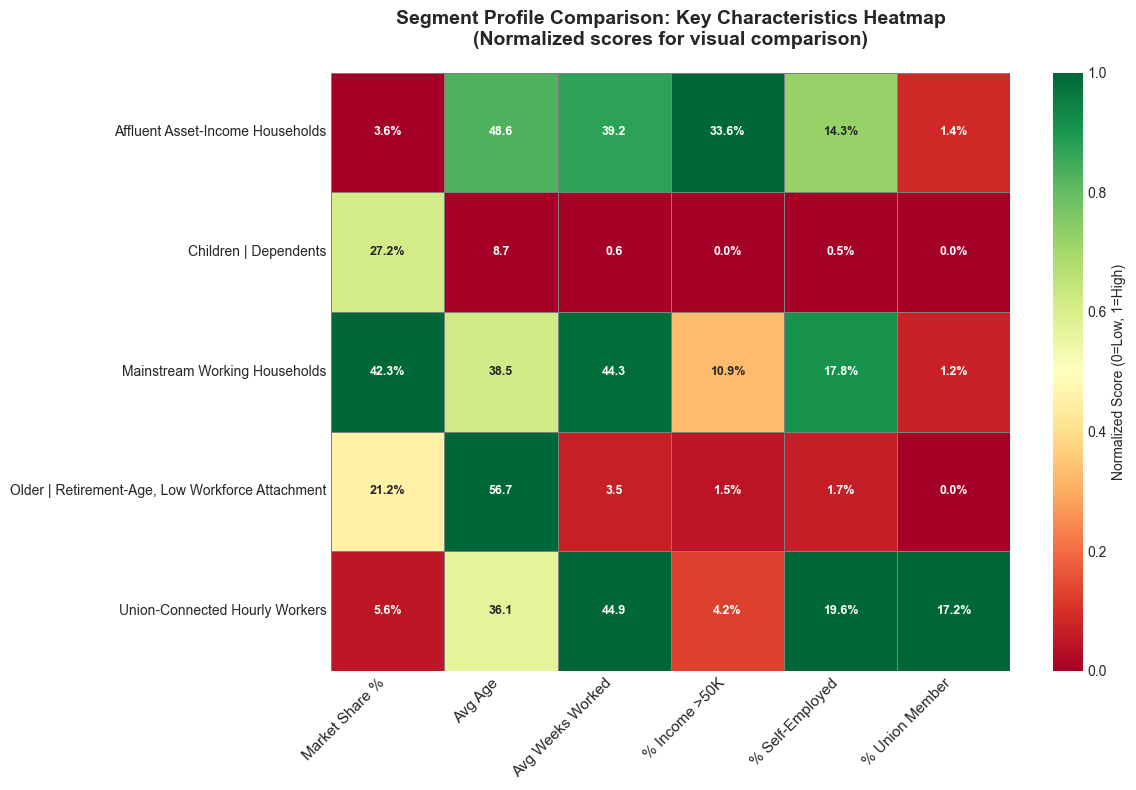


Key Insights from Heatmap:
- Darker green = Higher relative value for that metric
- Darker red = Lower relative value for that metric


In [ ]:
# Step 6.3: Create segment profile comparison heatmap
print("Step 6.3: Creating segment profile comparison heatmap...\n")

comparison_metrics = {
    'Market Share %': [segment_cards_df[segment_cards_df['Segment ID']==i]['Market Share %'].values[0] for i in sorted(df_work['final_segment_id'].unique())],
    'Avg Age': [segment_cards_df[segment_cards_df['Segment ID']==i]['Avg Age'].values[0] for i in sorted(df_work['final_segment_id'].unique())],
    'Avg Weeks Worked': [segment_cards_df[segment_cards_df['Segment ID']==i]['Avg Weeks Worked'].values[0] for i in sorted(df_work['final_segment_id'].unique())],
    '% Income >50K': [segment_cards_df[segment_cards_df['Segment ID']==i]['% Income >50K'].values[0] for i in sorted(df_work['final_segment_id'].unique())],
    '% Self-Employed': [segment_cards_df[segment_cards_df['Segment ID']==i]['% Self-Employed'].values[0] for i in sorted(df_work['final_segment_id'].unique())],
    '% Union Member': [segment_cards_df[segment_cards_df['Segment ID']==i]['% Union Member'].values[0] for i in sorted(df_work['final_segment_id'].unique())]
}

heatmap_df = pd.DataFrame(comparison_metrics, 
                          index=[segment_name_map[i].split(' (')[0] for i in sorted(df_work['final_segment_id'].unique())])

heatmap_normalized = heatmap_df.copy()
for col in heatmap_normalized.columns:
    min_val = heatmap_normalized[col].min()
    max_val = heatmap_normalized[col].max()
    if max_val > min_val:
        heatmap_normalized[col] = (heatmap_normalized[col] - min_val) / (max_val - min_val)
    else:
        heatmap_normalized[col] = 0

annot_matrix = np.empty((len(heatmap_df.index), len(heatmap_df.columns)), dtype=object)
for i in range(len(heatmap_df.index)):
    for j in range(len(heatmap_df.columns)):
        value = heatmap_df.iloc[i, j]
        if heatmap_df.columns[j] in ['Market Share %', '% Income >50K', '% Self-Employed', '% Union Member']:
            annot_matrix[i, j] = f'{value:.1f}%'
        else:
            annot_matrix[i, j] = f'{value:.1f}'

fig, ax = plt.subplots(figsize=(12, 8))

sns.heatmap(heatmap_normalized, annot=annot_matrix, fmt='', cmap='RdYlGn', 
            vmin=0, vmax=1, linewidths=0.5, linecolor='gray',
            cbar_kws={'label': 'Normalized Score (0=Low, 1=High)'},
            ax=ax, annot_kws={'fontsize': 9, 'fontweight': 'bold'})

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=11)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

ax.set_title('Segment Profile Comparison: Key Characteristics Heatmap\n(Normalized scores for visual comparison)', 
             fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("\nKey Insights from Heatmap:")
print("- Darker green = Higher relative value for that metric")
print("- Darker red = Lower relative value for that metric")